<a href="https://colab.research.google.com/github/vishalsahuu/Book-Recommendation-System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Title: Book Recommendation System**

## **Project Description**

### **Problem Statement**
---
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

### **Dataset Description**
---
The Book-Crossing dataset comprises 3 files.

* **Users:** Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

* **Books:** Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

* **Ratings:** Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.


## **Data Collection & Inspection**

In [1]:
# Importing important libraries and modules

# For data reading and manipulation
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
import seaborn as sns
import random

# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv datasets
df_books=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Books.csv')
df_ratings=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Ratings.csv')
df_users=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Users.csv')

In [3]:
# First look at the books dataset
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [5]:
# Description of the data
df_books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [6]:
# First look at the ratings dataset
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
# Description of the data
df_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [9]:
# First look at the users dataset
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Age column has alot of missing values.

In [11]:
# Description of the data
df_users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


There is the high imbalance in age column having max age of 244 and minimum age of 0 which could be due to some error.

In [12]:
# Size of datasets
print(f'''\t  Size of books data is {df_books.shape}
          Size of ratings data is {df_ratings.shape}
          Size of users data is {df_users.shape}''')

	  Size of books data is (271360, 8)
          Size of ratings data is (1149780, 3)
          Size of users data is (278858, 3)


In [13]:
# Duplicates in datasets
print(f'''\t  Duplicates in books data is {df_books.duplicated().sum()}
          Duplicates in ratings data is {df_ratings.duplicated().sum()}
          Duplicates in users data is {df_users.duplicated().sum()}''')

	  Duplicates in books data is 0
          Duplicates in ratings data is 0
          Duplicates in users data is 0


## **Data Pre-processing and Cleaning**

In [14]:
# Merging the data frames
merged_df=pd.merge(df_users,df_ratings,on='User-ID')
merged_df=pd.merge(merged_df,df_books,on='ISBN')

In [15]:
merged_df.head()

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8,"timmins, ontario, canada",NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,11400,"ottawa, ontario, canada",49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,11676,"n/a, n/a, n/a",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
4,41385,"sudbury, ontario, canada",NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   Location             1031136 non-null  object 
 2   Age                  753301 non-null   float64
 3   ISBN                 1031136 non-null  object 
 4   Book-Rating          1031136 non-null  int64  
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031135 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
 9   Image-URL-S          1031136 non-null  object 
 10  Image-URL-M          1031136 non-null  object 
 11  Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 102.3+ MB


In [17]:
# Size of the merged dataset
merged_df.shape

(1031136, 12)

In [18]:
# Total duplicates present in the data
merged_df.duplicated().sum()

0

In [19]:
# Dropping last three columns containing image URLs which will not be required for the analysis
merged_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

# Making column names handy to use
# Replacing '-' with '_' and column name in lower case
merged_df.columns= merged_df.columns.str.strip().str.lower().str.replace('-', '_')

# To display the entire content of a column
pd.set_option('display.max_colwidth', -1)

In [20]:
# Create a country column at the place of location 
merged_df['country'] = merged_df['location'].astype(str).apply(lambda x:x.split(',')[-1])
# Drop the location column
merged_df.drop('location',axis=1,inplace=True)

In [21]:
# Unique values in the country column
merged_df['country'].unique()

array([' usa', ' canada', ' n/a', '', ' malaysia', ' spain',
       ' new zealand', ' finland', ' united kingdom', ' portugal',
       ' brazil', ' germany', ' austria', ' italy', ' netherlands',
       ' australia', ' france', ' costa rica', ' poland', ' us', ' iran',
       ' aruba', ' india', ' pakistan', ' taiwan', ' singapore',
       ' argentina', ' romania', ' greece', ' ireland', ' philippines',
       ' belgium', ' philippines"', ' mexico', ' south africa',
       ' burkina faso', ' croatia', ' switzerland', ' denmark', ' rwanda',
       ' yugoslavia', ' turkey', ' china', ' japan', ' qatar', ' latvia',
       ' sweden', ' kuwait', ' indonesia', ' nepal', ' peru',
       ' venezuela', ' south korea"', ' hong kong', ' united states',
       ' slovakia', ' norway', ' dominican republic',
       ' bosnia and herzegovina', ' south korea', ' macedonia', ' kenya',
       ' mauritius', ' catalonia', ' nigeria', ' madagascar', ' israel',
       ' oman', ' egypt', ' lithuania', ' guate

In [22]:
# fix the unknown and missing values
merged_df['country'] = merged_df['country'].replace('','other').replace(' n/a','other')

In [23]:
# A function to get the missing values count and it's percentage
def missing_values(df):
  """
  This function takes a data frame as an input and gives missing value count and its percentage as an output
  """
  print(f'Count of missing values is \n{df.isnull().sum()}')
  print('-'*30)
  print(f'Percentage of missng values is \n{df.isnull().mean()*100}')

In [24]:
# Check for missing values
missing_values(merged_df)

Count of missing values is 
user_id                0     
age                    277835
isbn                   0     
book_rating            0     
book_title             0     
book_author            1     
year_of_publication    0     
publisher              2     
country                0     
dtype: int64
------------------------------
Percentage of missng values is 
user_id                0.000000 
age                    26.944554
isbn                   0.000000 
book_rating            0.000000 
book_title             0.000000 
book_author            0.000097 
year_of_publication    0.000000 
publisher              0.000194 
country                0.000000 
dtype: float64


In [25]:
merged_df.head()

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
0,2,18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,usa
1,8,NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada
2,11400,49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada
3,11676,NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,other
4,41385,NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada


In [26]:
# getting unique value from 'year_of_publication' feature
merged_df['year_of_publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1987, 1989, 1992, 1983, 1979, 1995, 1982, 1985, 1986,
       1978, 1980, 1952, 1990, 1981, 0, 1984, 1968, 1961, 1959, 1946,
       1974, 1958, 1976, 1971, '2002', 1977, 1975, 1965, 1941, 1970,
       '1996', '1999', 1972, '1989', '1992', '2001', 1953, 1962, 1973,
       '2004', 1960, '1997', '2000', '0', 1954, 1966, 1920, '1998',
       '2003', 1967, 1956, 1942, 1955, 1951, 1969, 1948, '1977', '1990',
       '1986', '1994', '1982', 1963, 1964, '1995', '1959', '1988', 1950,
       '1991', '1984', 2005, 1943, '1993', '1987', '1983', '1981', 1957,
       '1972', '1980', 1937, 1940, '1965', '1970', '1979', 1930, 1923,
       1945, 1947, '1976', 1936, '1985', '1978', 1925, '1966', '1958',
       '1975', '1973', 1927, '1974', '1967', '1971', '1969', 2030, '1968',
       2011, '1960', '1964', 2020, 1939, 1926, 1938, '1961', 1911, 1904,
       1949, 1932, 1929, '1953', '1963', '1955', '1944', '1920', '1

Instead of years here a couple of mismatched values are present.

In [27]:
# Rows where publisher was missing 
merged_df.loc[(merged_df['publisher'].isnull()),:]

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
857163,98391,52.0,193169656X,9,Tyrant Moon,Elaine Corvidae,2002,NaN,usa
857174,98391,52.0,1931696993,9,Finders Keepers,Linnea Sinclair,2001,NaN,usa


In [28]:
# Replacing NaN with Unknown
merged_df['publisher'].fillna('Unknown',inplace=True)

In [29]:
# Rows where book author was missing 
merged_df.loc[(merged_df['book_author'].isnull()),:]

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
857604,98647,26.0,9627982032,8,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing,malaysia


In [30]:
# Replacing NaN with Unknown
merged_df['book_author'].fillna('Unknown',inplace=True)

In [31]:
# Extracting the mismatched values in features 'year_of_publication', 'publisher', 'book_author', and 'book_title'
merged_df[(merged_df['year_of_publication'] == 'DK Publishing Inc') | (merged_df['year_of_publication'] == 'Gallimard')]

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
906829,130571,NaN,0789466953,0,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,usa
913994,137190,31.0,2070426769,0,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,france
946370,169663,NaN,078946697X,0,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,usa
946371,227771,19.0,078946697X,7,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,israel


In [32]:
# Function to replace values of different columns
def replace_values(df,index,column1,column2,column3,column4):
  temp = df.loc[index,column1]
  df.loc[index,column1] = df.loc[index,column2]
  df.loc[index,column2] = df.loc[index,column3].split(';')[1]
  df.loc[index,column4] = temp

In [33]:
# Fixing the mismatched values of features 'year_of_publication', 'publisher', 'book_author', and 'book_title'
replace_values(merged_df,906829,'year_of_publication','book_author','book_title','publisher')
replace_values(merged_df,913994,'year_of_publication','book_author','book_title','publisher')
replace_values(merged_df,946370,'year_of_publication','book_author','book_title','publisher')
replace_values(merged_df,946371,'year_of_publication','book_author','book_title','publisher')

In [34]:
merged_df['year_of_publication'] = merged_df['year_of_publication'].astype(int)

In [35]:
merged_df['year_of_publication'].sort_values().unique()

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050])

## **Exploratory Data Analysis**

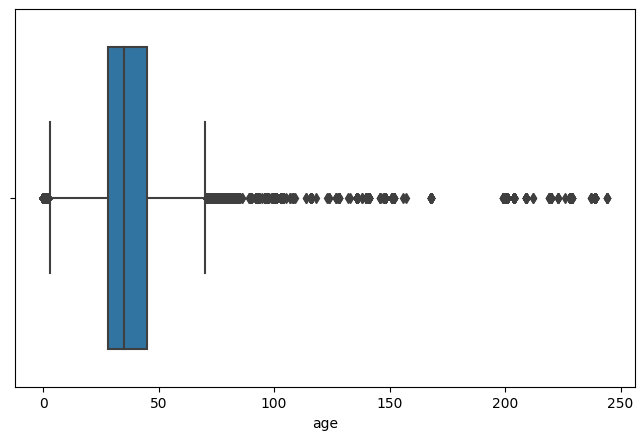

In [36]:
# Box plot for age
sns.boxplot(merged_df['age'])

It can be clearly seen that a lot of **outliers** are present in **age** column.

In [37]:
# Outlier data became NaN
merged_df.loc[(merged_df.age > 90) | (merged_df.age < 10), 'age'] = np.nan

In [38]:
# Null values in age column
nulls = sum(merged_df['age'].isnull())
print(nulls)

285733


In [39]:
# Imputing null values
median = merged_df['age'].median()
std = merged_df['age'].std()

# Fill invalid and missing ages with random normal distributed numbers
random_age = np.random.randint(median - std, median + std, size = nulls)
age = merged_df['age'].copy()
age[pd.isnull(age)] = random_age
merged_df['age'] = age
merged_df['age'] = merged_df['age'].astype(int)

In [40]:
missing_values(merged_df)

Count of missing values is 
user_id                0
age                    0
isbn                   0
book_rating            0
book_title             0
book_author            0
year_of_publication    0
publisher              0
country                0
dtype: int64
------------------------------
Percentage of missng values is 
user_id                0.0
age                    0.0
isbn                   0.0
book_rating            0.0
book_title             0.0
book_author            0.0
year_of_publication    0.0
publisher              0.0
country                0.0
dtype: float64


In [41]:
merged_df.shape

(1031136, 9)

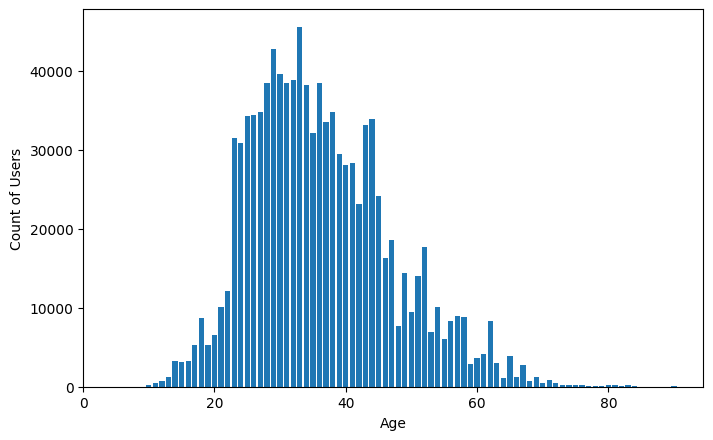

In [42]:
# Distribution of age after removing outliers and fixing missing values
u = merged_df.age.value_counts().sort_index()
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('Count of Users')
plt.xlim(xmin = 0)
plt.show()

It's observable that **maximum** number of users were of the **age** in between **20 to 45**. 

Text(0.5, 1.0, 'Top 10 authors with most number of books published')

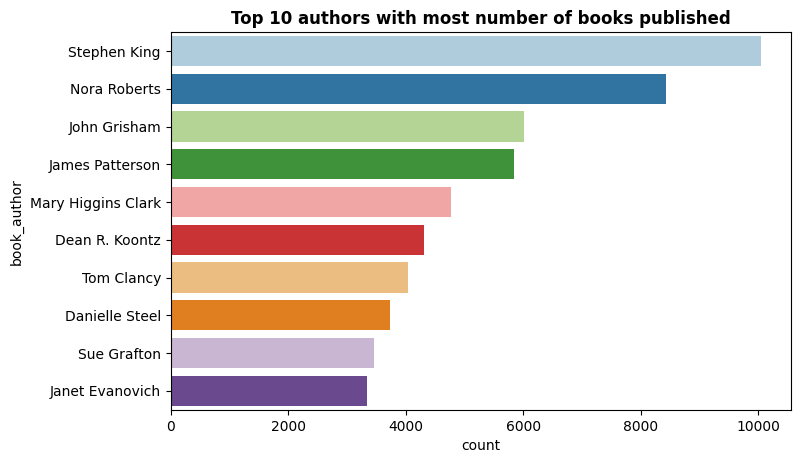

In [124]:
sns.countplot(y="book_author",palette = 'Paired', data=merged_df,order=merged_df['book_author'].value_counts().index[:10])
plt.title("Authors with most number of books published", fontweight='bold')

Text(0.5, 1.0, 'Top 10 Publishers')

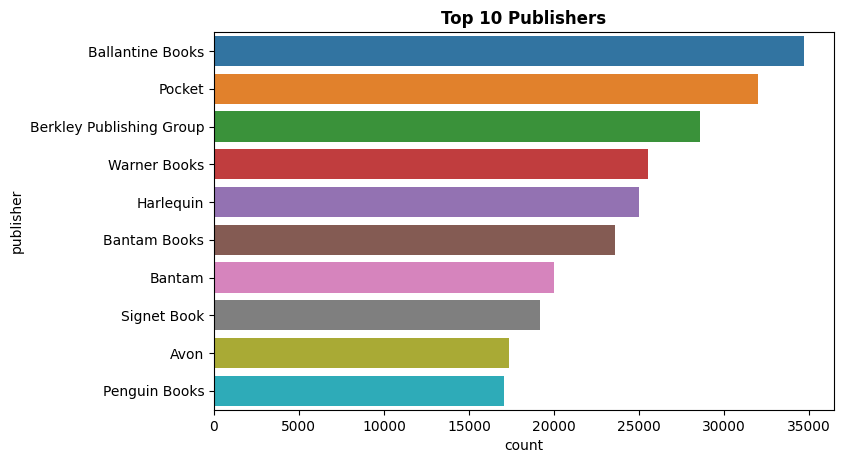

In [125]:
sns.countplot(y='publisher',data=merged_df,order=pd.value_counts(merged_df['publisher']).iloc[:10].index)
plt.title('Top 10 Publishers', fontweight='bold')

Publisher with **highest** number of books published was **Bllentine Books** followed by **Pocket**.

Text(0.5, 1.0, 'Top 5 countries')

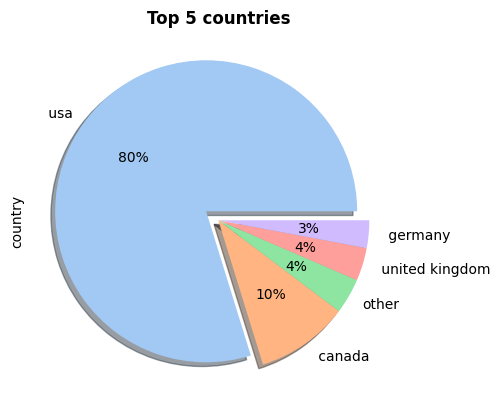

In [126]:
palette_color = sns.color_palette('pastel')
explode = (0.1, 0, 0, 0, 0)
merged_df.country.value_counts().iloc[:5].plot(kind='pie', colors=palette_color, autopct='%.0f%%', explode=explode, shadow=True)
plt.title('Top 5 countries', fontweight='bold')

Most of the **ratings** given were from **USA** followed by **Canada**.

In [127]:
merged_df[merged_df['year_of_publication']!=0]['year_of_publication'].value_counts()

2002    91800
2001    79801
1999    75194
2003    72539
2000    72329
        ...  
2008    1    
2012    1    
1378    1    
1897    1    
2024    1    
Name: year_of_publication, Length: 115, dtype: int64

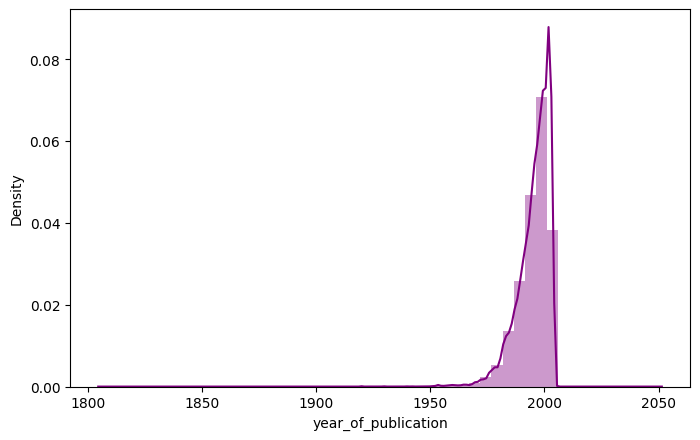

In [128]:
sns.distplot(merged_df[merged_df['year_of_publication']>1800]['year_of_publication'],color='purple',bins=50)

There was an exponential increase in **book publication** after the year **1950**.

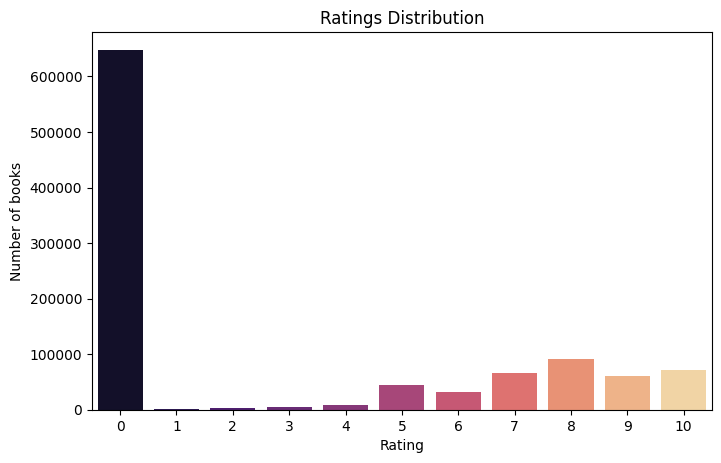

In [129]:
sns.barplot(x = merged_df['book_rating'].value_counts().index,y = merged_df['book_rating'].value_counts().values,
            palette = 'magma').set(title="Ratings Distribution", xlabel = "Rating",ylabel = 'Number of books')
plt.show()

Text(0.5, 1.0, 'Explicit Ratings')

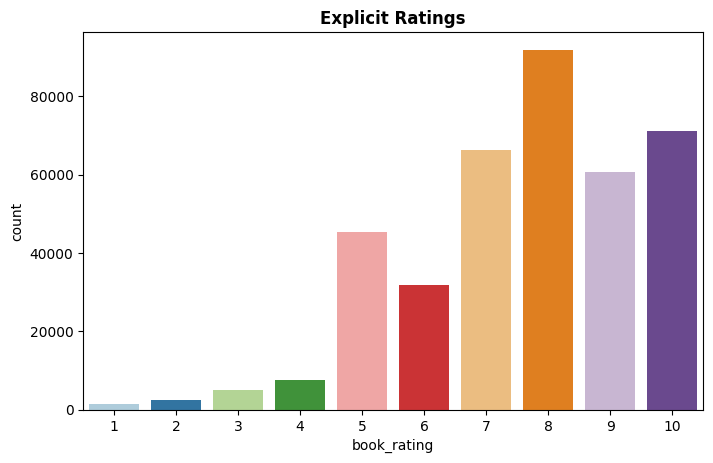

In [130]:
# Explicit Ratings
explicit_ratings_df = merged_df[merged_df['book_rating'] != 0]
sns.countplot(x="book_rating",palette = 'Paired',data=explicit_ratings_df)
plt.title("Explicit Ratings", fontweight='bold')

Countplot of explicit ratings indicates that **higher ratings** are more common amongst users and rating **8** has been rated highest number of times.

Text(0.5, 1.0, 'Top 10 most rated books')

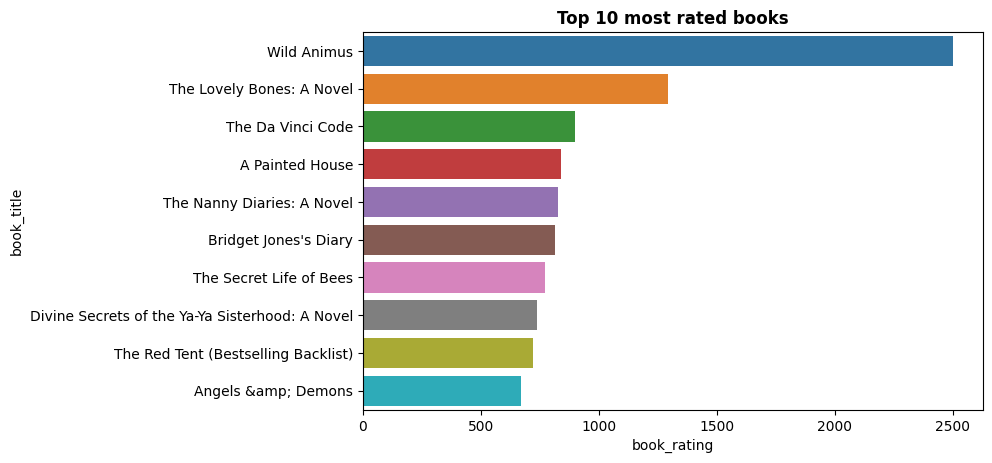

In [131]:
#Book ratings count using group by
book_rating = merged_df.groupby(['book_title'])['book_rating'].count().sort_values(ascending=False).reset_index()

sns.barplot(book_rating['book_rating'][:10],book_rating['book_title'][:10])
plt.title('Top 10 most rated books', fontweight='bold')

**Wild Animus** had got the most number ratings followed by **The Lovely Bones : A Novel** and **The Da Vinci Code**.

# **Recommender Systems**

## **Popularity Based Recommender System**

In [132]:
# A popular dataframe with book title, average ratings and number of ratings
explicit_ratings_df = merged_df[merged_df['book_rating']!=0]

In [133]:
# Create column average ratings using groupby on book title because some of the books have same book title but different isbn number
explicit_ratings_df['avg_ratings'] = explicit_ratings_df.groupby('book_title')['book_rating'].transform('mean')

# Create column number of ratings
explicit_ratings_df['no_of_ratings'] = explicit_ratings_df.groupby('book_title')['book_rating'].transform('count')

# Create new data frame popular_df
popular_df = explicit_ratings_df[['book_title','avg_ratings','no_of_ratings']]

In [134]:
# Drop duplicate books
popular_df.drop_duplicates('book_title',inplace=True)

In [135]:
popular_df.head()

,book_title,avg_ratings,no_of_ratings
1,Clara Callan,7.666667,9
16,Decision in Normandy,7.500000,2
19,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,7.833333,6
31,The Kitchen God's Wife,8.034483,116
64,What If?: The World's Foremost Military Historians Imagine What Might Have Been,7.000000,2


In [136]:
# Applying a constraint of number of ratings greater tha 200 to only keep the most popular books 
popular_df = popular_df[popular_df['no_of_ratings']>200].sort_values('avg_ratings',ascending=False)

In [137]:
# Top 50 recommended books
popular_df.head(50)

,book_title,avg_ratings,no_of_ratings
33024,Harry Potter and the Goblet of Fire (Book 4),9.125506,247
33219,Harry Potter and the Order of the Phoenix (Book 5),9.047393,211
32601,Harry Potter and the Prisoner of Azkaban (Book 3),9.043321,277
4219,To Kill a Mockingbird,8.977528,267
125266,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),8.936508,315
37807,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",8.882927,205
32080,Harry Potter and the Chamber of Secrets (Book 2),8.840491,326
130322,"Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",8.588000,250
12394,Fahrenheit 451,8.549020,204
27865,The Secret Life of Bees,8.477833,406


## **Collaborative Filtering Based Recommender System**

### **Item - Item**

* Every user's rating at facevalue can't be considered because if the user is a **novice reader** with only an experience of reading a couple of books, his/her ratings might not be much relevant for finding similarity among books.
* Therefore as a general rule of thumb let's consider only those Users who have rated atleast **50** books and only those books which have got atleast **15** ratings.

In [138]:
# Applying constraint on user id using it's count 
x = explicit_ratings_df.groupby('user_id').count()['book_rating'] > 50
filtered_df = explicit_ratings_df[explicit_ratings_df['user_id'].isin(x[x].index)]

In [140]:
# Applying constraint on number of rartings
y = filtered_df.groupby('book_title').count()['book_rating'] >= 15
filtered_df = filtered_df[filtered_df['book_title'].isin(y[y].index)]

In [141]:
filtered_df

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country,avg_ratings,no_of_ratings
31,11676,26,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,other,8.034483,116
32,29526,26,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,usa,8.034483,116
34,46398,37,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,usa,8.034483,116
54,230522,52,0399135782,7,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,usa,8.034483,116
58,245827,37,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,other,8.034483,116
...,...,...,...,...,...,...,...,...,...,...,...
1018771,254206,31,555053150X,9,Christine,Stephen King,1983,Viking Books,usa,8.052632,57
1021687,259901,28,0395647398,10,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1992,Houghton Mifflin,canada,9.330882,136
1025068,266865,33,0531001725,10,The Catcher in the Rye,Jerome David Salinger,1973,Scholastic Library Pub,usa,7.701887,265
1028347,274061,26,1551663147,10,Fever,Elizabeth Lowell,1997,Mira,usa,7.320000,25


In [142]:
# Form a user item matrix with values as ratings
pt = filtered_df.pivot_table(index='book_title',columns='user_id',values='book_rating').fillna(0)

In [143]:
pt

user_id,254,638,1424,1733,1903,2033,2110,2276,2766,2891,...,274004,274061,274111,274301,275970,276680,277427,278137,278188,278418
book_title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,9.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wuthering Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
from sklearn.metrics.pairwise import cosine_similarity

# Create an object of cosine similarity
similarity_scores = cosine_similarity(pt)

In [145]:
# Matrix size 
similarity_scores.shape

(827, 827)

In [146]:
def recommend(book_name):
  """
This funtion will take a book name as an input and will return top 5 similar books
  """
  # Fetch index
  index = np.where(pt.index==book_name)[0][0]
  similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:6]
  
  for i in similar_items:
      print(pt.index[i[0]])

In [147]:
recommend('1984')

Animal Farm
Brave New World
The Handmaid's Tale
The Catcher in the Rye
The Alchemist: A Fable About Following Your Dream


In [148]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Create an object of csr matrix
df_matrix = csr_matrix(pt.values)

In [149]:
# Building a KNN model with Cosine Similarity as the target metric for calculating the distances.
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors=5)
knn.fit(pt)

NearestNeighbors(algorithm='brute', metric='cosine')

In [150]:
# Building item to item recommendation model for the book readers
def recommend(movie, n_values=11):
  distances, indices = knn.kneighbors(pt.loc[movie,:].values.reshape(1, -1), n_neighbors = n_values)
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'The Top {n_values - 1} Recommendations for Users who have read book {movie} are shown below:-')
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, pt.index[indices.flatten()[i]], distances.flatten()[i]))

In [151]:
recommend('1984')

The Top 10 Recommendations for Users who have read book 1984 are shown below:-
1: Animal Farm, with distance of 0.6527664998052591.
2: Brave New World, with distance of 0.7280981748396947.
3: The Handmaid's Tale, with distance of 0.7583219351897921.
4: The Catcher in the Rye, with distance of 0.7864809605296995.
5: The Alchemist: A Fable About Following Your Dream, with distance of 0.8030441955254175.
6: Naked, with distance of 0.8056016646009073.
7: The Vampire Lestat (Vampire Chronicles, Book II), with distance of 0.8067346342193303.
8: Timeline, with distance of 0.8068737245545161.
9: American Psycho (Vintage Contemporaries), with distance of 0.8086056915824844.
10: The Hitchhiker's Guide to the Galaxy, with distance of 0.8120482961710292.


### **User - User**

Recommender systems have a problem known as user **cold-start**, in which it is hard to provide **personalized** recommendations for users with none or a very few number of consumed items, due to the **lack** of information to model their preferences. For this reason, we are keeping in the dataset only users with at least **5** interactions.

In [200]:
users_interactions_count_df = explicit_ratings_df.groupby(['book_title', 'user_id']).size().groupby('user_id').size()
print('Number of users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 100].reset_index()[['user_id']]
print('Number of users with at least 100 interactions: %d' % len(users_with_enough_interactions_df))

Number of users: 68091
Number of users with at least 100 interactions: 449


In [201]:
print('Number of interactions: %d' % len(explicit_ratings_df))
interactions_from_selected_users_df = explicit_ratings_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('Number of interactions from users with at least 100 interactions: %d' % len(interactions_from_selected_users_df))

Number of interactions: 383842
Number of interactions from users with at least 100 interactions: 103271


In [202]:
interactions_from_selected_users_df.head()

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country,avg_ratings,no_of_ratings
0,2033,27,0439064864,9,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,usa,8.840491,326
1,2033,27,0439136350,9,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,usa,9.043321,277
2,2033,27,0439139597,9,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,usa,9.125506,247
3,2033,27,043935806X,9,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,2003,Scholastic,usa,9.047393,211
4,2033,27,0590353403,9,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,usa,9.062500,176


In [225]:
import scipy
import math
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

In [226]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df.groupby(['book_title','user_id'])['book_rating'].sum().apply(smooth_user_preference).reset_index()
print('Number of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

Number of unique user/item interactions: 102497


,book_title,user_id,book_rating
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",96448,3.321928
1,Dark Justice,98391,3.459432
2,"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",26544,3.321928
3,Final Fantasy Anthology: Official Strategy Guide (Brady Games),101851,3.459432
4,"Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750",46398,3.000000


In [227]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(explicit_ratings_df['book_title'].unique())

LabelEncoder()

In [228]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, 
                                   test_size=0.20,
                                   stratify=interactions_full_df['user_id'],
                                   random_state=42)

print('Number of interactions on Train set: %d' % len(interactions_train_df))
print('Number of interactions on Test set: %d' % len(interactions_test_df))

Number of interactions on Train set: 81997
Number of interactions on Test set: 20500


In [229]:
interactions_train_df['book_title'] = le.transform(interactions_train_df['book_title'])
interactions_test_df['book_title'] = le.transform(interactions_test_df['book_title'])

interactions_train_df.head()

,book_title,user_id,book_rating
59075,81747,168245,3.169925
99261,131025,156467,3.459432
41678,56706,8890,3.000000
95210,125040,56959,2.584963
68758,94312,76499,3.459432


In [230]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='user_id', 
                                                          columns='book_title', 
                                                          values='book_rating').fillna(0)

users_items_pivot_matrix_df.head()

book_title,0,2,3,4,8,11,13,14,16,18,...,135527,135530,135531,135533,135536,135537,135538,135539,135542,135548
user_id,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [232]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[2033, 2110, 2276, 4017, 4385, 5582, 6242, 6251, 6543, 6575]

#### Singular Value Decomposition 

In [233]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

# Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [234]:
users_items_pivot_matrix.shape

(449, 51965)

In [235]:
U.shape

(449, 15)

In [236]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [237]:
Vt.shape

(15, 51965)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [238]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 1.10297341e-03,  6.79700081e-04,  1.22970564e-03, ...,
        -4.89497633e-03,  1.83708027e-02,  1.75592869e-03],
       [ 3.73514874e-04,  5.37765662e-04,  3.35547316e-04, ...,
         9.51004069e-04,  7.48425350e-03,  4.51230976e-04],
       [ 1.48203888e-04,  1.57978998e-03,  8.39205302e-04, ...,
         2.23697470e-03, -6.63959618e-04,  6.66296898e-04],
       ...,
       [ 1.35058641e-03, -8.18320940e-04,  5.67802798e-04, ...,
         9.91684938e-03,  2.50984502e-02,  1.14992523e-03],
       [ 7.55416209e-04, -1.85732053e-03,  1.11361537e-03, ...,
         7.95858844e-03,  1.08441675e-02,  1.22007024e-03],
       [ 8.43059947e-05, -2.59568757e-04,  4.35371958e-04, ...,
         6.44131658e-04,  1.18108986e-04,  3.53854626e-04]])

In [239]:
all_user_predicted_ratings.shape

(449, 51965)

In [240]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
book_title,,,,,,,,,,,,,,,,,,,,,
0,0.001103,0.000374,0.000148,0.002646,-0.000117,0.000687,0.002214,0.002723,0.001410,0.004742,...,0.001298,0.002130,0.002727,0.001630,-0.001019,0.000296,0.000909,0.001351,0.000755,0.000084
2,0.000680,0.000538,0.001580,0.000987,0.000908,0.003522,-0.001408,-0.002999,0.004786,-0.000802,...,-0.002406,-0.000499,-0.003607,-0.001779,0.001831,0.004957,-0.003407,-0.000818,-0.001857,-0.000260
3,0.001230,0.000336,0.000839,0.000897,0.000196,0.001224,0.000756,0.001673,0.000830,0.001868,...,0.001059,0.001720,0.001806,0.000909,0.002681,0.004324,0.001955,0.000568,0.001114,0.000435
4,0.016749,0.003796,0.007909,0.002822,0.001832,0.013786,-0.000160,0.016234,0.004583,0.006838,...,0.010890,0.012019,0.011121,0.006844,0.032390,0.050813,0.019699,0.006489,0.011541,0.004938
8,0.010079,0.003403,0.002534,0.018312,-0.000631,0.006409,0.016212,0.021415,0.010808,0.034037,...,0.010089,0.018157,0.020797,0.012696,-0.004884,0.010326,0.011186,0.009650,0.006989,0.001545


In [241]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['book_title'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'book_title', 
                                                          right_on = 'book_title')[['recStrength', 'book_title']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, explicit_ratings_df)

#### **Evaluation**

In Recommender Systems, there are a set metrics commonly used for evaluation. We choose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

This evaluation method works as follows:

* For each user
    * For each item the user has interacted in test set
        * Sample 100 other items the user has never interacted.   
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed of one interacted item and the 100 non-interacted items
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N accuracy metrics

In [242]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

`The Top-N accuracy metric choosen was **Recall@N** which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

In [246]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['book_title']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [247]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(explicit_ratings_df['book_title'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['book_title']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['book_title'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['book_title'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['book_title'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['book_title'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()  

In [248]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
448 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.5110243902439024, 'recall@10': 0.5110243902439024}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
4,622,622,1339,0.464526,0.464526,11676
12,358,358,1130,0.316814,0.316814,98391
28,60,60,365,0.164384,0.164384,189835
5,163,163,364,0.447802,0.447802,153662
30,65,65,234,0.277778,0.277778,23902
33,128,128,203,0.630542,0.630542,235105
205,45,45,202,0.222772,0.222772,76499
97,67,67,191,0.350785,0.350785,171118
71,118,118,189,0.624339,0.624339,16795
306,70,70,188,0.372340,0.372340,248718


In [253]:
rec = cf_recommender_model.recommend_items(270713)
rec = le.inverse_transform(rec['book_title'])
print(rec)

['The Red Tent (Bestselling Backlist)' 'The Lovely Bones: A Novel'
 'Harry Potter and the Chamber of Secrets (Book 2)'
 'To Kill a Mockingbird' 'Harry Potter and the Goblet of Fire (Book 4)'
 'The Secret Life of Bees' 'Jurassic Park' "Bridget Jones's Diary"
 'Dreamcatcher' 'A Prayer for Owen Meany']


In [252]:
merged_df[merged_df['user_id']==270713].head()

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,country
3977,270713,27,0312978383,0,Winter Solstice,Rosamunde Pilcher,2001,St. Martin's Paperbacks,canada
4061,270713,27,0553278398,0,Prelude to Foundation (Foundation Novels (Paperback)),ISAAC ASIMOV,1989,Spectra,canada
6991,270713,27,0804106304,8,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),canada
9513,270713,27,0786868716,10,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,canada
11962,270713,27,0671004573,6,Before I Say Good-Bye,Mary Higgins Clark,2001,Pocket,canada
